In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.sans-serif"] = [u"SimHei"]
mpl.rcParams["axes.unicode_minus"] = False
import pymysql
import argparse, os, sys, json
from sqlalchemy import create_engine
import tkinter as tk
from pyecharts.charts import Map
from pyecharts import options as opts 

## 1.向mysql导入数据

In [3]:
#创建写入sql的engine
parser = argparse.ArgumentParser()
parser.add_argument('-user', help="mysql database user", type=str, required=False, default='root')
parser.add_argument('-pw', help="password", type=str, required=False, default='aa88606256,,')
parser.add_argument('-host', help="ip address", type=str, required=False, default='localhost')
parser.add_argument('-db', help="database name", type=str, required=False, default='zhongjingwang')
parser.add_argument('-charset', help="character set to use", type=str, required=False, default='utf8')
sys.argv = ['-f']
args = parser.parse_args()
# helper functions 
sql = lambda command: pd.read_sql(command, con)
def fetch(command):
    cursor.execute(command)
    return cursor.fetchall()
con = pymysql.connect(host=args.host, user=args.user, password=args.pw, use_unicode=True, charset=args.charset)
cursor = con.cursor()
""" insert dataset to database """
# db_data = 'mysql+pymysql://' + '<USER-NAME>' + ':' + '<PASSWORD>' + '@' + '***.***.***.***' + ':3306/' + '<DB-NAME>' + '?charset=utf8mb4'
db_data = "mysql+pymysql://{}:{}@{}:3306/{}?charset={}".format(args.user, args.pw, args.host, args.db, args.charset)
engine = create_engine(db_data).connect()
sql('use zhongjingwang')

""


In [42]:
# 批量处理表并写入database
def excel_to_sql(path):
    df = pd.read_excel(path,skiprows=[2,3],header=None)
    i = 1
    drop_cols = []
    while i < df.shape[1]:
        if df.iloc[1,i] == '全国':
            drop_cols.append(i)
        i += 1
    df = df.drop(labels=drop_cols,axis=1)
    df = pd.DataFrame(df.values.T)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df = df.melt(id_vars = ["地区","指标"],var_name = "月份")
    df = df.set_index(["地区","月份","指标"])
    df = df.unstack().reset_index()
    index = []
    for i in df.columns:
        if i[0] == 'value':
            index.append(i[1])
        else:
            index.append(i[0])
    df.columns = index
    df.to_sql(name=path[path.rfind('\\')+1:path.rfind('.')], con=engine, if_exists='replace')

In [5]:
#向数据库写入所有excel
import os
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.xls')]
img_path = get_imlist("数据")
for path in img_path:
    excel_to_sql(path)

In [13]:
sql("show tables in zhongjingwang")

,Tables_in_zhongjingwang
0,低保人数
1,保险
2,公路客运量
3,农业
4,原油
5,商品房销售额
6,固定资产投资
7,国内贸易
8,地区生产总值
9,天然气


## 2.数据预处理（已运行，不需要再次运行）

In [53]:
sql('use zhongjingwang;')

""


In [5]:
#贵州地区单位是万人，需要×10000
sql('''
    SELECT 地区, 农村居民最低生活保障人数_期末 FROM 低保人数 
WHERE 月份 = "2021-10"
''')


,地区,农村居民最低生活保障人数_期末
0,上海,33000.0
1,云南,2278000.0
2,内蒙古,1310000.0
3,北京,39000.0
4,吉林,541000.0
5,四川,3643000.0
6,天津,62000.0
7,宁夏,383000.0
8,安徽,1772000.0
9,山东,1361000.0


In [10]:
#处理单位不统一，需要把万人转化为人，乘10000
sql("UPDATE 低保人数 SET 农村居民最低生活保障人数_期末 = 农村居民最低生活保障人数_期末 * 10000 where 地区 = '贵州'")
con.commit()

In [7]:
sql("UPDATE 低保人数 SET 城市居民最低生活保障人数_期末 = 城市居民最低生活保障人数_期末 * 10000 where 地区 = '贵州'")
con.commit()

In [12]:
#处理浮点数误差，人数需要转换为整数
sql("UPDATE 低保人数 SET 农村居民最低生活保障人数_期末 = round(农村居民最低生活保障人数_期末) where 地区 = '贵州'")
con.commit()

In [59]:
sql("SELECT * FROM 保险 WHERE 地区 = '浙江'")

,index,地区,月份,原保险保费收入_累计
0,432,浙江,2019-11,2433.70
1,433,浙江,2019-12,2627.00
2,434,浙江,2020-01,579.20
3,435,浙江,2020-02,738.05
4,436,浙江,2020-03,1026.26
5,437,浙江,2020-04,1226.83
6,438,浙江,2020-05,1427.44
7,439,浙江,2020-06,1682.69
8,440,浙江,2020-07,1868.83
9,441,浙江,2020-08,2072.86


In [13]:
#单位不统一，亿元需要乘10000
sql("UPDATE 保险 SET 原保险保费收入_累计 = 原保险保费收入_累计 * 10000 where 地区 = '浙江'")
con.commit()

In [61]:
#完全缺失列 固定资产投资(不含农户)_累计
sql("SELECT * FROM `固定资产投资`")

,index,地区,月份,固定资产投资(不含农户)_累计同比增速
0,0,上海,2019-11,5.0
1,1,上海,2019-12,5.1
2,2,上海,2020-02,-7.2
3,3,上海,2020-03,-9.3
4,4,上海,2020-04,-3.6
...,...,...,...,...
677,677,黑龙江,2021-06,15.2
678,678,黑龙江,2021-07,11.3
679,679,黑龙江,2021-08,8.3
680,680,黑龙江,2021-09,8.2


In [66]:
sql("SELECT 地区, 社会消费品零售总额_累计 FROM 国内贸易 where 地区 = '北京' OR 地区 = '广东' OR 地区 = '上海'")

,地区,社会消费品零售总额_累计
0,上海,12214.40
1,上海,13497.20
2,上海,2049.12
3,上海,3060.34
4,上海,4208.43
...,...,...
61,广东,2145.80
62,广东,2507.70
63,广东,2878.70
64,广东,3260.10


In [14]:
#单位不统一，亿元需要乘10000
sql("UPDATE 国内贸易 SET 社会消费品零售总额_累计 = 社会消费品零售总额_累计 * 0.00001 where 地区 = '北京' OR 地区 = '广东'")
con.commit()

In [15]:
#处理浮点数误差，转为一位小数
sql("UPDATE 国内贸易 SET 社会消费品零售总额_累计 = ROUND(社会消费品零售总额_累计,1) where 地区 = '北京' OR 地区 = '广东'")
con.commit()

In [82]:
sql("SELECT * FROM 国内贸易 where 地区 = '北京' OR 地区 = '广东'")

,index,地区,月份,社会消费品零售总额_累计,社会消费品零售总额_累计同比增速
0,66,北京,2019-11,1119.5,None
1,67,北京,2019-12,1227,4.4
2,68,北京,2020-02,186.2,None
3,69,北京,2020-03,271.6,-21.47
4,70,北京,2020-04,369.3,None
5,71,北京,2020-05,473.8,None
6,72,北京,2020-06,597.3,-16.3
7,73,北京,2020-07,698.8,None
8,74,北京,2020-08,815,None
9,75,北京,2020-09,939,-13.1


In [67]:
sql("SELECT 地区 , 月份 , GDP_累计 FROM 地区生产总值")

,地区,月份,GDP_累计
0,上海,2015-12,24965.00
1,上海,2016-03,6225.39
2,上海,2016-06,12957.00
3,上海,2016-09,19529.70
4,上海,2016-12,27466.20
...,...,...,...
739,黑龙江,2020-09,8619.67
740,黑龙江,2020-12,13698.50
741,黑龙江,2021-03,2692.47
742,黑龙江,2021-06,5990.49


In [16]:
#将所有数值型变量设置为数值形式
df_var = pd.read_excel('变量汇总.xlsx')
for i in range(df_var.shape[0]):
    sql_str = 'ALTER TABLE `zhongjingwang`.`'
    sql_str += df_var.iloc[i,1]
    sql_str += '` CHANGE COLUMN `'
    sql_str += df_var.iloc[i,2]
    sql_str += '` `'
    sql_str += df_var.iloc[i,2]
    sql_str += '` FLOAT NULL DEFAULT NULL ;'
    try:
        sql(sql_str)
        con.commit()
    except TypeError:
        continue
    #print(df_var.iloc[i,1],df_var.iloc[i,2])

## 3.软件功能实现DEMO

In [52]:
#绘制地图
data = sql('SELECT * FROM 居民收入支出 WHERE 月份 = "2020-12"')[['地区','居民人均可支配收入_累计']]
data = [[data['地区'][i],data['居民人均可支配收入_累计'][i]] for i in range(len(data['地区']))]
def draw_a_map(data):
    #provinces   = data[0]
    #school_nums = data[1]
    mm = Map()
    mm.add('居民收入', data, "china")
    mm.set_global_opts(
        #title_opts=opts.TitleOpts(title="居民可支配收入"),
        #visualmap_opts=opts.VisualMapOpts(max_=8, is_piecewise=True, split_number=4),
        visualmap_opts=opts.VisualMapOpts(max_=72232.0),
    )
    mm.render("map.html")
    a = '"C:/Program Files/Internet Explorer/iexplore.exe" '  + os.getcwd() + '\map.html'
    os.system(a)
draw_a_map(data)

In [72]:
#用tkinter编写界面，实现数据立方体上卷、下钻操作
import tkinter as tk

window = tk.Tk()
window.title('my window')
window.geometry('800x800')

var1 = tk.StringVar()
l = tk.Label(window, bg='yellow', width=4, textvariable=var1)
l.pack()

def print_selection():
    value = lb.get(lb.curselection())
    var1.set(value)

b1 = tk.Button(window, text='print selection', width=15,
              height=2, command=print_selection)
b1.pack()

var2 = tk.StringVar()

var2.set([i[0] for i in sql("show tables in zhongjingwang").values])
lb = tk.Listbox(window, listvariable=var2)
lb.pack()

window.mainloop()

In [104]:
#全年
sql('''
      SELECT SUBSTR(月份,1,4) AS 年份, SUM(农村居民最低生活保障人数_期末) AS 农村居民最低生活保障人数_期末
      FROM 低保人数 
      WHERE 月份 LIKE '%12'
      GROUP BY 年份
''')

,年份,农村居民最低生活保障人数_期末
0,2019,3.248657e+07
1,2020,3.410508e+07


In [105]:
#月份
sql('''
      SELECT 月份, SUM(农村居民最低生活保障人数_期末) AS 农村居民最低生活保障人数_期末
      FROM 低保人数 
      GROUP BY 月份
''')

,月份,农村居民最低生活保障人数_期末
0,2019-11,3.253296e+07
1,2019-12,3.248657e+07
2,2020-01,3.261163e+07
3,2020-02,3.261977e+07
4,2020-03,3.272214e+07
5,2020-04,3.309386e+07
6,2020-05,3.339641e+07
7,2020-06,3.378746e+07
8,2020-07,3.400024e+07
9,2020-08,3.403618e+07


In [152]:
#全年，某地区
sql('''
      SELECT SUBSTR(月份,1,4) AS 年份, SUM(农村居民最低生活保障人数_期末) AS 农村居民最低生活保障人数_期末
      FROM 低保人数 
      WHERE 月份 LIKE '%12' AND 地区 = '广东'
      GROUP BY 年份
''')

,年份,农村居民最低生活保障人数_期末
0,2019,1247123.0
1,2020,1277643.0


In [126]:
#月份，某地区
df = sql('''
      SELECT 月份, SUM(农村居民最低生活保障人数_期末) AS 农村居民最低生活保障人数_期末
      FROM 低保人数 
      WHERE 地区 = '广东'
      GROUP BY 月份
''')
df.keys()[1][:df.keys()[1].rfind('_')]

'农村居民最低生活保障人数'

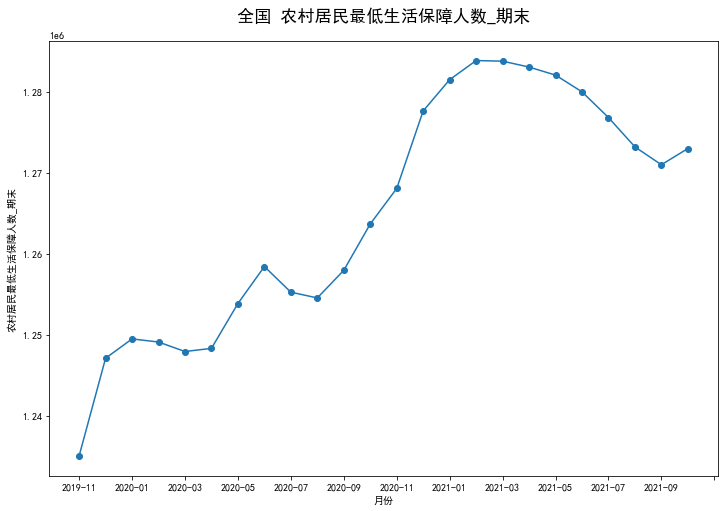

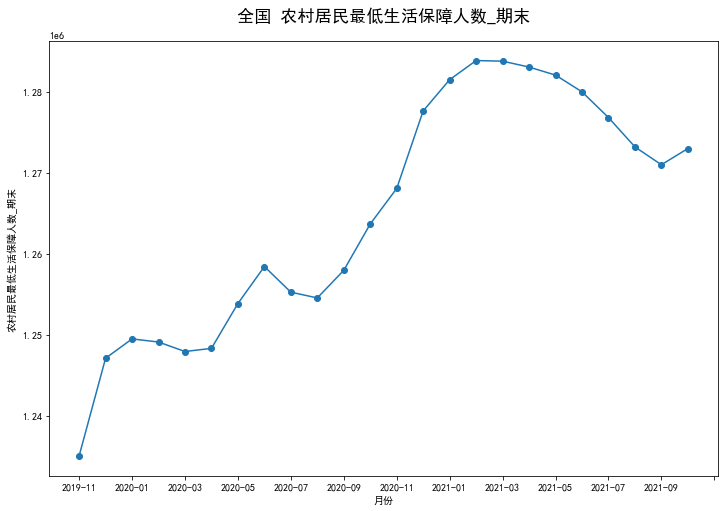

In [138]:
#绘制折线图
df = sql('''
      SELECT 月份, SUM(农村居民最低生活保障人数_期末) AS 农村居民最低生活保障人数_期末
      FROM 低保人数 
      WHERE 地区 = '广东'
      GROUP BY 月份
''')
from matplotlib.pyplot import MultipleLocator
def fun1(df,region='全国'):
    #x = np.arange(50)
    #列表中存放6种颜色
    #colors = ["r","y","g","b","c","m"]
    #字典中存放6条线的不同样式
    #kind = {"circle":"o","start":"*","traggle_donw":"v","dash_dot":"-","dash_line":"--","x-mark":"x"}
    f = plt.figure(figsize=(12,8))
    fig1=plt.subplot(1,1,1)
    plt.plot(df.iloc[:,0],df.iloc[:,1],"o-")
    #for index,key in zip(np.arange(6),kind.keys()):
        #符合正态分布的随机数
        #y = np.random.randn(50)
        #plt.plot(x,y,kind[key],color=colors[index],label=key)
    #plt.legend()
    fig1.set_xlabel(df.keys()[0]) 
    fig1.set_ylabel(df.keys()[1])
    title = region + ' ' + df.keys()[1]
    fig1.set_title(title,loc='center',pad=20,fontsize='xx-large',color='black')
    x_major_locator=MultipleLocator(2)
    ax=plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    return f
#fun1(df,region='广东')
fun1(df)